In [1]:
# Copyright 2018 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)

Populating the interactive namespace from numpy and matplotlib


In [3]:
import matplotlib.pyplot as plt
import numpy
import seaborn
import wordcloud

# Python Community Insights With Public Data

Using the the [PyPI public dataset](https://bigquery.cloud.google.com/dataset/the-psf:pypi) and the [StackOverflow public dataset](https://bigquery.cloud.google.com/dataset/bigquery-public-data:stackoverflow) what are some insights we can get about the Python community?

We'll be using Pandas and the Google Cloud client libraries.

In [4]:
from google.cloud import bigquery
bigquery.__version__

'0.29.0'

In [5]:
client = bigquery.Client()

## What versions of Python are being used to download packages?

Using the the [PyPI public dataset](https://bigquery.cloud.google.com/dataset/the-psf:pypi), get a count of how many downloads there have been for each Python version in January 2018 so far.

In [6]:
pypi_query = """
#standardSQL
SELECT
  REGEXP_EXTRACT(details.python, r"[0-9]+\.[0-9]+") AS python_version,
  COUNT(*) AS downloads
FROM `the-psf.pypi.downloads201801*`
WHERE details.installer.name = 'pip'
GROUP BY python_version
ORDER BY downloads DESC
"""
pypi_df = client.query(pypi_query).to_dataframe()

In [7]:
pypi_df

,python_version,downloads
0,2.7,258729018
1,3.6,32940225
2,3.5,28946392
3,3.4,13775681
4,2.6,3496679
5,3.3,339018
6,3.7,258071
7,3.2,19410
8,None,11072
9,3.1,45


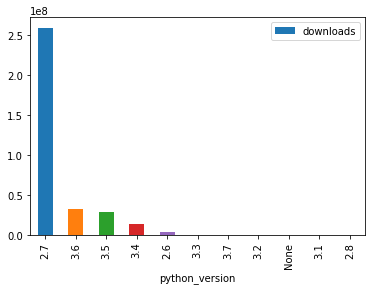

In [8]:
pypi_df.plot.bar('python_version', 'downloads')

We see that a significant portion of downloads are still using Python 2.7, but there is a visible portion using Python 3.x, with about half of those on Python 3.6.

For a deeper exploration of this dataset and how you can use it to learn about your favorite package, check out [Paul Kehrer's blog post](https://langui.sh/2016/12/09/data-driven-decisions/) and the [pypinfo CLI tool](https://github.com/ofek/pypinfo).

## What questions do people ask about Python?

Using the [StackOverflow public dataset](https://bigquery.cloud.google.com/dataset/bigquery-public-data:stackoverflow), what are the most popular questions people have about Python?

In [9]:
so_query = """
#standardSQL
SELECT
  id, title, view_count
FROM `bigquery-public-data.stackoverflow.posts_questions`
WHERE tags like '%python%'
ORDER BY view_count DESC
LIMIT 100
"""
so_df = client.query(so_query).to_dataframe()

In [10]:
so_df.head(20)

,id,title,view_count
0,379906,Parse String to Float or Int,2552109
1,82831,How do I check whether a file exists using Pyt...,2375647
2,423379,Using global variables in a function other tha...,2304607
3,3294889,Iterating over dictionaries using 'for' loops,2266294
4,89228,Calling an external command in Python,2199177
5,3277503,How do I read a file line-by-line into a list?,2171631
6,961632,Converting integer to string in Python?,2071316
7,3437059,Does Python have a string 'contains' substring...,2017197
8,176918,Finding the index of an item given a list cont...,2012245
9,4750806,How do I install pip on Windows?,1995864


The most popular question is about how to [parse a string to a float or integer](https://stackoverflow.com/questions/379906/parse-string-to-float-or-int). All of these questions are about working with Python itself and not any specific package. Some top topics include:

- built-in objects like strings and dictionaries
- time
- parsing

Let's build a word cloud to see what topics pop out.

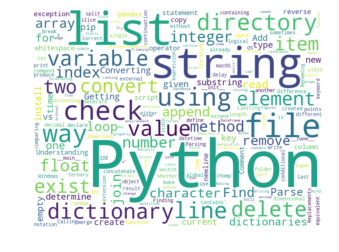

In [11]:
wc = wordcloud.WordCloud(
    width=800, height=600, background_color='white')
wc.generate(' '.join(so_df.title))
plt.axis('off')
plt.imshow(wc, interpolation='bilinear')

## Are some packages harder to use?

The nice thing about BigQuery is that if you have access to several datasets, you can join them together. Even though the PyPI dataset is in `the-psf` project and the StackOverlow dataset is in the `bigquery-public-data` project, we can still join them together.

I'm interested to know which packages have more questions per download in 2017.

In [12]:
qpd_query = """
#standardSQL
SELECT
  project,
  SUM(questions) / downloads AS qpd,
  SUM(questions) AS total_questions,
  downloads
FROM (
  SELECT
    file.project AS project,
    COUNT(*) AS downloads
  FROM `the-psf.pypi.downloads2017*`
  WHERE details.installer.name = 'pip'
  GROUP BY project ) pypi
JOIN (
  SELECT
    tags,
    COUNT(*) AS questions
  FROM `bigquery-public-data.stackoverflow.posts_questions`
  WHERE tags LIKE '%python%'
  GROUP BY tags ) so
ON pypi.project IN UNNEST(SPLIT(so.tags, '|'))
WHERE pypi.downloads >= 10000
GROUP BY project, downloads
ORDER BY qpd DESC
"""
qpd_df = client.query(qpd_query).to_dataframe()

In [13]:
qpd_df.head(20)

,project,qpd,total_questions,downloads
0,list,2.242787,29385,13102
1,opencv,0.273075,8778,32145
2,heroku,0.222330,2302,10354
3,django-rest-framework,0.196306,3975,20249
4,sqlite,0.151021,3779,25023
5,html,0.130751,10932,83609
6,facebook,0.099267,1381,13912
7,json,0.095657,12908,134941
8,math,0.095255,2686,28198
9,urllib2,0.094008,2694,28657


Some of these, like the [list package](https://pypi.org/project/List/1.3.0/) do exist, but refer to built-in modules / types and were likely downloaded by mistake.

Others, like `opencv` and `boost` really are pretty complex packages, so I'm not too surprised that there are more questions about them.

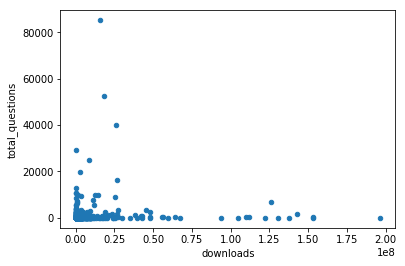

In [15]:
qpd_df.plot.scatter('downloads', 'total_questions')

There isn't an obvious trend, but we see that our query has grabbed some of those outliers with many questions and relatively few downloads.